# import Library

In [45]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from surprise import KNNBasic
from surprise import SVD
from surprise import accuracy
from sklearn import preprocessing
from surprise import CoClustering
from surprise import SlopeOne
import os, io

# load in data & preprocessing

In [46]:
df  = pd.read_csv('data/automotive.csv',delimiter=",")# read csv into ratings_df dataframe

In [47]:
# restrict the columns for uid,iid, and rating for surprise
df = df[['reviewerID','asin','overall']]

In [48]:
print(df.head())

       reviewerID        asin  overall
0   ABCA1A8E4DGV1  0209688726        1
1  A1NX8HM89FRQ32  0209688726        1
2  A1X77G023NY0KY  0209688726        3
3  A3GK37JO2MGW6Q  0209688726        5
4   AIY18YON1TWJJ  0209688726        5


In [49]:
# check for any missing values
df.isna().sum()

reviewerID    0
asin          0
overall       0
dtype: int64

In [50]:
print('No. of Unique Users    :', df.reviewerID.nunique())
print('No. of Unique Business :', df.asin.nunique())
print('No. of Unique Ratings  :', df.overall.nunique())

No. of Unique Users    : 161088
No. of Unique Business : 75894
No. of Unique Ratings  : 5


In [51]:
df.shape

(936196, 3)

In [52]:
# anaylizing the values of rating. Looks like there is no negative value
df.describe()

,overall
count,936196.000000
mean,4.474212
std,1.054637
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [53]:
df['overall'].value_counts()

5    686420
4    124176
3     53338
1     44603
2     27659
Name: overall, dtype: int64

(array([ 44603.,      0.,  27659.,      0.,      0.,  53338.,      0.,
        124176.,      0., 686420.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

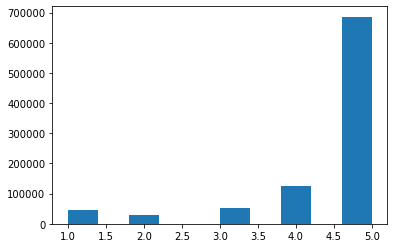

In [54]:
plt.hist(df['overall'])

## remove duplicates( same uid + iid but different rating) 

In [55]:
df = df.drop_duplicates(['reviewerID','asin'])

In [56]:
# 24849 duplicate rows dropped (936196 - 911347)
df.shape

(911347, 3)

In [57]:
# rename columns for better readability
df.columns = ['uid', 'iid','rating']

In [58]:
df_copy = df.copy()

In [59]:
df_copy = df_copy.iloc[:100000,:]

In [60]:
df_copy.shape

(100000, 3)

in order to use our own custom dataset(csv) to be used with the surprise library algorithms we must run it through the reader object to parse the dataset.

In [61]:
reader = Reader(rating_scale=(1,5))
data=Dataset.load_from_df(df,reader)

In [62]:
data_copy=Dataset.load_from_df(df_copy,reader)

# split dataset to train and test

train= 80% of total and test =  remaining 20% of data

In [63]:
trainingSet, testSet = train_test_split(data, test_size=0.2, train_size=None, random_state=None, shuffle=True)

In [64]:
trainingSet_small , testSet_small = train_test_split(data_copy, test_size=0.2, train_size=None, random_state=None, shuffle=True)

# Training and testing model on default param to compare rmse

In [65]:
algo_svd = SVD()
algo_cluster = CoClustering()

In [66]:
algo_svd.fit(trainingSet)
algo_cluster.fit(trainingSet)

In [67]:
algo_slope = SlopeOne()

In [68]:
algo_slope.fit(trainingSet_small)

In [69]:
predictions_svd = algo_svd.test(testSet)

In [70]:
predictions_cluster = algo_cluster.test(testSet)

In [71]:
predictions_slope = algo_slope.test(testSet_small)

In [72]:
from sklearn.metrics import accuracy_score

In [77]:
accuracy.rmse(predictions_svd, verbose=True) 

RMSE: 0.9916


0.9915781204770667

In [78]:
accuracy.rmse(predictions_cluster, verbose=True) 

RMSE: 1.0849


1.084870812234753

In [80]:
accuracy.rmse(predictions_slope, verbose=True) 

RMSE: 1.0323


1.0323466205596397

# GridSearch

In [73]:
param_grid_svd = {'n_epochs': [5,10,20,30], 'lr_all': [0.001, 0.003, 0.005,0.007],
              'reg_all': [0.01, 0.02,0.05,0.1], 'n_factors': [20,50,100,200]}

In [74]:
param_grid_cluster = {'n_cltr_u': [1,2,3,4,5], 'n_cltr_i': [1,2,3,4,5],
              'n_epochs': [5,10,20,30]}

In [83]:
# default param of svd = {'n_epochs': 20, 'lr_all':0.005,
              #'reg_all':0.02, 'n_factors': 100}
 # default param of cluster = {''n_cltr_u':3, 'n_cltr_i':3,
             # 'n_epochs':20}   

In [75]:
gs_cluster = GridSearchCV(CoClustering, param_grid_cluster, measures=['rmse', 'mae'], cv=3)

In [76]:
gs = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=3)

In [77]:
gs.fit(data)

In [78]:
gs_cluster.fit(data)

In [79]:
gs_cluster.best_params['rmse']

{'n_cltr_u': 1, 'n_cltr_i': 2, 'n_epochs': 20}

In [82]:
gs.best_params['rmse']

{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05, 'n_factors': 20}

In [90]:
algo_svd_optimal = SVD(n_epochs = 30, lr_all=0.005, reg_all=0.05, n_factors=20 )

In [84]:
algo_cluster_optimal = CoClustering(n_cltr_u=1, n_cltr_i=2, n_epochs=20)

In [86]:
algo_cluster_optimal.fit(trainingSet)

In [91]:
algo_svd_optimal.fit(trainingSet)

In [92]:
predictions_svd_final = algo_svd_optimal.test(testSet)

In [87]:
predictions_cluster_final = algo_cluster_optimal.test(testSet)

In [93]:
accuracy.rmse(predictions_svd_final, verbose=False) 

0.9823428860295582

In [95]:
accuracy.rmse(predictions_cluster_final, verbose=False) 

1.0768154361119149